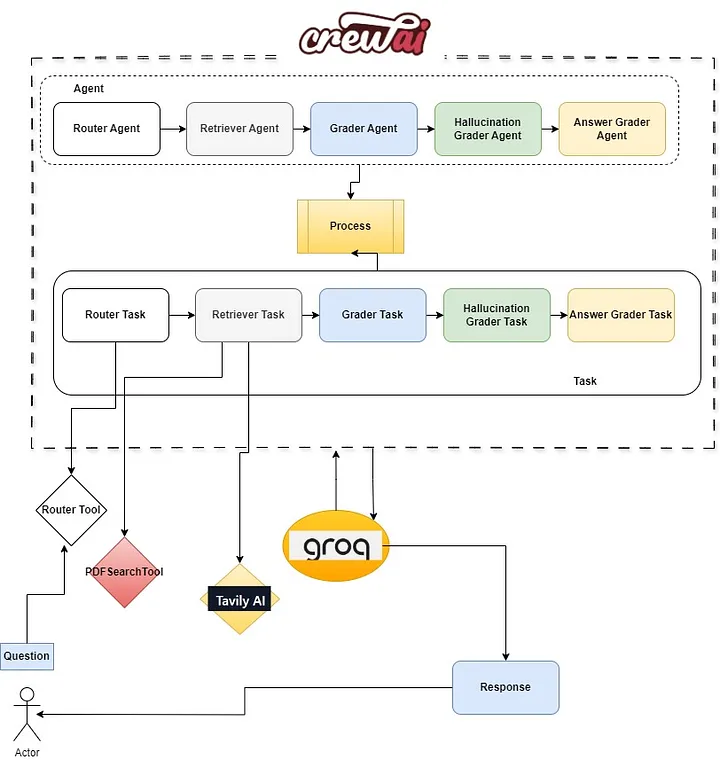

Here we will build a RAG Agent which will generate response for the question asked by retrieving relevant context if bthe question asked is about ESOPs otherwise the Agent will perform a web search to retrieve the required context and formulate a response that can be presented to the user.

**The RAG agent comprises of the following components:**

*  Router Agent: This agent decides whether to perform a RAG or external web search based on the context of the question asked.
*  Retriever Agent : This Agent retrieves context relevant to the question asked based on the mode suggested by the Router Agent.
*  Grader Agent: This Agent grades the context retrieved and check for the context relevancy with question asked.
*  Hallucination Grader Agent : This Agents grades the response from Retriever agent based on Usefulness and Facts
*  Answer Grader Agent: This Agent Generates the Final Response.
*  Router Task : Define task and expected output layout for Router Agent
*  Retriever Task: Define task and expected output layout for Retriever Agent
*  Grader Task : Define task and expected output layout for Grader Agent
*  Hallucination Grader Task: Define task and expected output layout for Hallucination Grader Agent
*  Answer Task : Define task and expected output layout for Answer grader Agent
*  Web Search Tool : Tool to perform external search
*  PDFSearchTool : CrewAI RAG tool designed for semantic searches within PDF content.
*  Llama3–8B as the Large Language Model

Code Implementation
Code implemented in Google Colab using CPU

Install Required Dependencies

In [1]:
!pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29 langchain-groq langchain-huggingface

  Using cached crewai-0.28.8-py3-none-any.whl.metadata (13 kB)
  Using cached crewai_tools-0.1.6-py3-none-any.whl.metadata (4.6 kB)
  Using cached langchain_community-0.0.29-py3-none-any.whl.metadata (8.3 kB)
  Using cached langchain_groq-0.2.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached langchain_huggingface-0.1.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached embedchain-0.1.123-py3-none-any.whl.metadata (9.3 kB)
  Using cached instructor-0.5.2-py3-none-any.whl.metadata (10 kB)
  Using cached langchain-0.1.20-py3-none-any.whl.metadata (13 kB)
  Using cached openai-1.52.0-py3-none-any.whl.metadata (24 kB)
  Using cached opentelemetry_api-1.27.0-py3-none-any.whl.metadata (1.4 kB)
  Using cached opentelemetry_exporter_otlp_proto_http-1.27.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached opentelemetry_sdk-1.27.0-py3-none-any.whl.metadata (1.5 kB)
  

**Libereies:**

In [3]:
#from google.colab import userdata
import os
from langchain_groq import ChatGroq
from crewai import Agent, Task, Crew, Process
from crewai_tools import SerperDevTool,PDFSearchTool,ScrapeWebsiteTool
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
#from google.colab import userdata
from crewai_tools  import tool
import os

 setup the API_KEY

In [4]:

os.environ['GROQ_API_KEY'] = "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"#replace with your Groq api key

# Set the Tavily API key
os.environ['TAVILY_API_KEY'] = "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"#replace with your Tavily Api Key
# os.environ["SERPER_API_KEY"]=userdata.get("SERPER_API_KEY")#replace with Serper Api Key

Setup the LLM

In [5]:

llm=ChatGroq(model="llama-3.2-90b-text-preview")

In [6]:
llm.invoke("How does exercise price determine for ESOP?")

AIMessage(content="The exercise price, also known as the strike price or option price, for an Employee Stock Option Plan (ESOP) is typically determined by the company's board of directors or a designated committee. Here are some common methods used to determine the exercise price:\n\n1. **Fair Market Value (FMV)**: The exercise price is set at the fair market value of the company's stock on the date the option is granted. This is usually determined by an independent valuation firm or by using a formula based on recent stock trades.\n2. **Grant Date Value**: The exercise price is set at the closing price of the company's stock on the date the option is granted.\n3. **Average Trading Price**: The exercise price is set at the average trading price of the company's stock over a specified period, such as 30 days or 6 months, before the grant date.\n4. **Discounted Price**: The exercise price may be set at a discounted price, which is lower than the fair market value. This is often used for 

Download input data for RAG(ESOP info)

In [7]:
!wget "https://www.icsi.edu/media/webmodules/CSJ/January/17.pdf"  

zsh:1: command not found: wget


***Create Tools***

Define the PDFSerachTool using custom model and embeddings

The PDFSearchTool is a RAG tool designed for semantic searches within PDF content. It allows for inputting a search query and a PDF document, leveraging advanced search techniques to find relevant content efficiently. This capability makes it especially useful for extracting specific information from large PDF files quickly.

In [8]:

rag_tool = PDFSearchTool(pdf='/Users/sabrc/Documents/WorkShop2_Crew_Ai/Narayan_Submission_IJDAR_paper.pdf',
    config=dict(
        llm=dict(
            provider="groq", # or google, openai, anthropic, llama2, ...
            config=dict(
                model="llama3-8b-8192",
                # temperature=0.5,
                # top_p=1,
                # stream=true,
            ),
        ),
        embedder=dict(
            provider="huggingface", # or openai, ollama, ...
            config=dict(
                model="BAAI/bge-small-en-v1.5",
                #task_type="retrieval_document",
                # title="Embeddings",
            ),
        ),
    )
)

/Users/sabrc/Documents/WorkShop2_Crew_Ai/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
Inserting batches in chromadb: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


In [9]:
rag_tool.run("What are the PDF parser tools used?")

Using Tool: Search a PDF's content


'Relevant Content:\nA Comparative Study of PDF Parsing Tools Across Diverse Document Categories Narayan S. Adhikari1*and Shradha Agarwal1,2 1JadooAI, ,Sacramento, California, United States. 2Department, Organization, Street, City, 10587, State, Country. *Corresponding author(s). E-mail(s): n.adhikari2010@gmail.com; Contributing authors: iiauthor@gmail.com; Abstract PDF is one of the most prominent data formats, making PDF parsing crucial for information extraction and retrieval, particularly with the rise of RAG sys- tems. While various PDF parsing tools exist, their effectiveness across different document types remains understudied, especially beyond academic papers. Our research aims to address this gap by comparing 10 popular PDF parsing tools across 6 document categories using the DocLayNet dataset. We evaluated both text extraction and table detection capabilities. For text extraction, PyMuPDF and pypdfium generally outperformed others, but all parsers struggled with Sci- entific 

Create Web Search Tool

In [10]:
#set your Api keys
from langchain_community.tools.tavily_search import TavilySearchResults
search_tool=TavilySearchResults(k=3)
#
# search_tool= SerperDevTool()
# scrape_tool = ScrapeWebsiteTool()

Create Custom Tool to facilitate the Router Agent

In [49]:
from crewai_tools  import tool
@tool
def router_tool(question):
  """Router Function"""
  if 'scientific documents' in question: #scientific documents, pdf parsers, accuracies, blue, 
    return 'vectorstore'
  else:
    return 'websearch'


Define our agents
Agent Parameters used :
Role : Defines the agent’s function within the crew. It determines the kind of tasks the agent is best suited for.
Goal : The individual objective that the agent aims to achieve. It guides the agent’s decision-making process.
Backstory :Provides context to the agent’s role and goal, enriching the interaction and collaboration dynamics.
LLM (optional): Represents the language model that will run the agent. It dynamically fetches the model name from the OPENAI_MODEL_NAME environment variable, defaulting to "gpt-4" if not specified.
Verbose (optional): Setting this to True configures the internal logger to provide detailed execution logs, aiding in debugging and monitoring. Default is False.
Allow Delegation (optional): Agents can delegate tasks or questions to one another, ensuring that each task is handled by the most suitable agent. Default is True.

router Agent


In [12]:
Router_Agent = Agent(
  role='Router',
  goal='Route user question to a vectorstore or search the internet',
  backstory=(
    "You are an expert at routing a user question to a vectorstore or web search."
    "Use the vectorstore for questions on concept related to Retrieval-Augmented Generation."
    "You do not need to be stringent with the keywords in the question related to these topics. Otherwise, use web-search."
  ),
  verbose=True,
  allow_delegation=False,
  llm=llm,
)

2. Retriever Agent

In [13]:
Retriever_agent = Agent(
    role="Retriever Agent",
    goal="Use the information retrieved from the vectorstore or web to answer the question",
    backstory=("You are an assistant for question-answering tasks."
    "Use the information present in the retrieved context to answer the question."
    "You have to provide a clear concise answer."
),
    verbose=True,
    allow_delegation=False,
    # tools=[rag_tool, search_tool, scrape_tool],  # Ensure vectorstore_tool, search_tool, and scrape_tool are correctly defined
    llm=llm,  # LLM for processing complex queries and handling context
    # action_handlers={
    #     "Search the internet": search_tool.run,  # Action for searching the
    #     "Scrape content": scrape_tool.run,  # Action for scraping detailed info from web
    #     "Search a PDF's content": rag_tool.run  # Action for retrieving from vectorstore
    # }
)

3. Grader Agent



In [14]:
Grader_agent =  Agent(
  role='Answer Grader',
  goal='Filter out erroneous retrievals',
  backstory=(
    "You are a grader assessing relevance of a retrieved document to a user question."
    "If the document contains keywords related to the user question, grade it as relevant."
    "It does not need to be a stringent test.You have to make sure that the answer is relevant to the question."
  ),
  verbose=True,
  allow_delegation=False,
  llm=llm,
)

4. Hallucination Grader Agent

In [15]:
hallucination_grader = Agent(
    role="Hallucination Grader",
    goal="Filter out hallucination",
    backstory=(
        "You are a hallucination grader assessing whether an answer is grounded in / supported by a set of facts."
        "Make sure you meticulously review the answer and check if the response provided is in alignmnet with the question asked"
    ),
    verbose=True,
    allow_delegation=False,
    llm=llm,
)

5. Answer Grader Agent

In [16]:
answer_grader = Agent(
    role="Answer Grader",
    goal="Filter out hallucination from the answer.",
    backstory=(
        "You are a grader assessing whether an answer is useful to resolve a question."
        "Make sure you meticulously review the answer and check if it makes sense for the question asked"
        "If the answer is relevant generate a clear and concise response."
        "If the answer gnerated is not relevant then perform a websearch using 'web_search_tool'"
    ),
    verbose=True,
    allow_delegation=False,
    llm=llm,
)

**Define Tasks for the agents**

**Task Parameters**

*   Description: A clear, concise statement of what the task entails.
*  Agent: The agent responsible for the task, assigned either directly or by the crew’s process.
*   Expected Output: A detailed description of what the task’s completion looks like.
*   Tools (optional): The functions or capabilities the agent can utilize to perform the task
*   Context (optional): Specifies tasks whose outputs are used as context for this task.



1.Router Task

In [50]:
router_task = Task(
    description=("Analyse the keywords in the question {question}"
    "Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool."
    "Return a single word 'vectorstore' if it is eligible for vectorstore search."
    "Return a single word 'websearch' if it is eligible for web search."
    "Do not provide any other premable or explaination."
    ),
    expected_output=("Give a binary choice 'websearch' or 'vectorstore' based on the question"
    "Do not provide any other premable or explaination."),
    agent=Router_Agent,
    tools=[router_tool],
    action_handlers={
        "router_tool": router_tool.run
    }
)

2. Retriever Task

In [18]:

retriever_task = Task(
    description=("Based on the response from the router task extract information for the question {question} with the help of the respective tool."
    "In case the router task output is 'websearch' ,then  use the serach_tool to retrieve information from the web "
    "In case the router task output is 'vectorstore', then use the rag_tool to retrieve information from the vectorstore in case the router task output is 'vectorstore'."
                 ),
    expected_output=("You should analyse the output of the 'router_task"
    "If the response (output) is 'websearch' then use the Search the internet (search_tool) to retrieve information from the web."
    "If the response (output) is 'vectorstore' then use the Search a PDF's content (rag_tool) to retrieve information from the vectorstore."
    "Return a claer and consise text as response."),
    agent=Retriever_agent,
    content=[router_task],
    tools=[rag_tool,search_tool],# Ensure the router task provides context for the search
    action_handlers={
        "Search the internet": search_tool.run,  # Action for searching the
        "Search a PDF's content": rag_tool.run  # Action for retrieving from vectorstore
    }
    )



3. Grader Task

In [19]:
grader_task = Task(
    description=("Based on the response from the retriever task for the quetion {question} evaluate whether the retrieved content is relevant to the question."
    ),
    expected_output=("Binary score 'yes' or 'no' score to indicate whether the document is relevant to the question"
    "You must answer 'yes' if the response from the 'retriever_task' is in alignment with the question asked."
    "You must answer 'no' if the response from the 'retriever_task' is not in alignment with the question asked."
    "Do not provide any preamble or explanations except for 'yes' or 'no'."),
    agent=Grader_agent,
    context=[retriever_task],
)

4. Hallucination Grader Task

In [20]:
hallucination_task = Task(
    description=("Based on the response from the grader task for the quetion {question} evaluate whether the answer is grounded in / supported by a set of facts."),
    expected_output=("Binary score 'yes' or 'no' score to indicate whether the answer is sync with the question asked"
    "Respond 'yes' if the answer is in useful and contains fact about the question asked."
    "Respond 'no' if the answer is not useful and does not contains fact about the question asked."
    "Do not provide any preamble or explanations except for 'yes' or 'no'."),
    agent=hallucination_grader,
    context=[grader_task],
)

5. Answer grader Task

In [21]:
answer_task = Task(
    description=("Based on the response from the hallucination task for the quetion {question} evaluate whether the answer is useful to resolve the question."
    "If the answer is 'yes' return a clear and concise answer."
    "If the answer is 'no' then perform a 'websearch' and return the response"),
    expected_output=("Return a clear and concise response if the response from 'hallucination_task' is 'yes'."
    "Perform a web search using 'web_search_tool' and return ta clear and concise response only if the response from 'hallucination_task' is 'no'."
    "Otherwise respond as 'Sorry! unable to find a valid response'."),
    context=[hallucination_task],
    agent=answer_grader,

)

**Setup the Crew**

In CrewAI, processes orchestrate the execution of tasks by agents, akin to project management in human teams. These processes ensure tasks are distributed and executed efficiently, in alignment with a predefined strategy

**Process Implementations**

*  Sequential: Executes tasks sequentially, ensuring tasks are completed in an orderly progression.
*  Hierarchical: Organizes tasks in a managerial hierarchy, where tasks are delegated and executed based on a structured chain of command. A manager language model (manager_llm) must be specified in the crew to enable the hierarchical process, facilitating the creation and management of tasks by the manager.
*  Consensual Process (Planned): Aiming for collaborative decision-making among agents on task execution, this process type introduces a democratic approach to task management within CrewAI. It is planned for future development and is not currently implemented in the codebase.
By default the process is implemented as a Sequential process if no process is mentioned.

In [33]:
rag_crew = Crew(
    agents=[Router_Agent, Retriever_agent, Grader_agent, hallucination_grader, answer_grader],
    tasks=[router_task, retriever_task, grader_task, hallucination_task, answer_task],
    verbose=True,

)

2024-10-21 13:03:28,279 - 8239708864 - __init__.py-__init__:538 - WARNING: Overriding of current TracerProvider is not allowed


Define the input

In [36]:
inputs ={"question":"Which city is the largest in North America?"}

***Kickoff the Crew***

In [37]:
result = rag_crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question Which city is the largest in North America?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: The question "Which city is the largest in North America?" does not contain any keywords related to Retrieval-Augmented Generation concepts. 

Action: router_tool
Action Input: {"question": "Which city is the largest in North America?", "context": "determine search type"} 

I encountered an error while trying to use the tool. This was the error: router_tool() got an unexpected keyword argument 'context'.
 Tool router_tool accepts these inputs: router_tool() - Router Function

Thought: The qu

In [38]:
result

'Mexico City is the largest city in North America.'

Let us test agent by agent functioning and completion
Test The Router Agent

In [40]:
rag_crew = Crew(
    agents=[Router_Agent],
    tasks=[router_task],
    verbose=True,

)
inputs ={"question":"Which city is the largest in North America?"}
result = rag_crew.kickoff(inputs=inputs)

2024-10-21 13:15:40,382 - 8239708864 - __init__.py-__init__:538 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question Which city is the largest in North America?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: I need to determine whether the question "Which city is the largest in North America?" is related to Retrieval-Augmented Generation concepts or not.

Action: router_tool
Action Input: {"input_text": "Which city is the largest in North America?"} 

I encountered an error while trying to use the tool. This was the error: router_tool() got an unexpected keyword argument 'input_text'.
 Tool router_tool accepts these inputs: router_tool() - Router Function

Thought: I need to determine whether th

2. Test the Retriever Agent

In [41]:
rag_crew = Crew(
    agents=[Router_Agent,Retriever_agent],
    tasks=[router_task,retriever_task],
    verbose=True,

)
inputs ={"question":"Which city is the largest in North America?"}
result = rag_crew.kickoff(inputs)

2024-10-21 13:16:11,436 - 8239708864 - __init__.py-__init__:538 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question Which city is the largest in North America?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: Analyze the keywords in the question to determine the search type
Action: router_tool
Action Input: {"question": "Which city is the largest in North America?"} 

websearch

Thought: I now know the final answer
Final Answer: websearch

> Finished chain.
 [DEBUG]: == [Router] Task output: websearch


 [DEBUG]: == Working Agent: Retriever Agent
 [INFO]: == Starting Task: Based on the response from the router task extract information for the question Which city is the largest in North America? w

3. Test the Grader Agent

In [42]:
rag_crew = Crew(
    agents=[Router_Agent,Retriever_agent,Grader_agent],
    tasks=[router_task,retriever_task,grader_task],
    verbose=True,

)
inputs ={"question":"Which city is the largest in North America ?"}
result = rag_crew.kickoff(inputs=inputs)

2024-10-21 13:20:32,677 - 8239708864 - __init__.py-__init__:538 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question Which city is the largest in North America ?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: Analyze the question to determine the type of search required
Action: router_tool
Action Input: {"question": "Which city is the largest in North America ?", "keyphrases": ["Retrieval-Augmented Generation"]} 

I encountered an error while trying to use the tool. This was the error: router_tool() got an unexpected keyword argument 'keyphrases'.
 Tool router_tool accepts these inputs: router_tool() - Router Function

Thought: Analyze the question to determine the type of search required
Action

4. Test the Hallucination Grader Agent

In [43]:
rag_crew = Crew(
    agents=[Router_Agent,Retriever_agent,Grader_agent,hallucination_grader],
    tasks=[router_task,retriever_task,grader_task,hallucination_task],
    verbose=True,

)
inputs ={"question":"Which city is the largest in North America?"}
result = rag_crew.kickoff(inputs=inputs)

2024-10-21 13:21:35,577 - 8239708864 - __init__.py-__init__:538 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question Which city is the largest in North America?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: Analyze the question to determine if it's related to Retrieval-Augmented Generation concepts or not.

Action: router_tool
Action Input: {"question": "Which city is the largest in North America?", "search_type": "eligibility"} 

I encountered an error while trying to use the tool. This was the error: router_tool() got an unexpected keyword argument 'search_type'.
 Tool router_tool accepts these inputs: router_tool() - Router Function

Thought: I need to re-analyze the question to determine if

5. Test the Answer Grader Agent

In [44]:
rag_crew = Crew(
    agents=[Router_Agent,Retriever_agent,Grader_agent,hallucination_grader,answer_grader],
    tasks=[router_task,retriever_task,grader_task,hallucination_task,answer_task],
    verbose=True,

)
inputs ={"question":"Which city is the largest in North America?"}
result = rag_crew.kickoff(inputs=inputs)

2024-10-21 13:23:35,334 - 8239708864 - __init__.py-__init__:538 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question Which city is the largest in North America?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: Analyze the question to determine the suitable search method
Action: router_tool
Action Input: {"question": "Which city is the largest in North America?"} 

websearch

Thought: Analyze the question to determine the suitable search method
Action: router_tool
Action Input: {"question": "Which city is the largest in North America?"} 

I tried reusing the same input, I must stop using this action input. I'll try something else instead.



Thought: Analyze the keywords in the question to determin

Test the Agent with topic not related to ESOP

In [46]:
rag_crew = Crew(
    agents=[Router_Agent, Retriever_agent, Grader_agent, hallucination_grader, answer_grader],
    tasks=[router_task, retriever_task, grader_task, hallucination_task, answer_task],
    verbose=True,

)
#
inputs = {"question":"Which is the national bird of Equador?"}
result = rag_crew.kickoff(inputs=inputs)

2024-10-21 13:31:10,614 - 8239708864 - __init__.py-__init__:538 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question Which is the national bird of Equador?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: Analyzing the question to determine whether it's related to Retrieval-Augmented Generation or not.
Action: router_tool
Action Input: {"input_text": "Which is the national bird of Equador?"} 

I encountered an error while trying to use the tool. This was the error: router_tool() got an unexpected keyword argument 'input_text'.
 Tool router_tool accepts these inputs: router_tool() - Router Function

Thought: Analyzing the question to determine whether it's related to Retrieval-Augmented Generation 

Testing the Agent on a new question related to ESOP

In [51]:
rag_crew = Crew(
    agents=[Router_Agent, Retriever_agent, Grader_agent, hallucination_grader, answer_grader],
    tasks=[router_task, retriever_task, grader_task, hallucination_task, answer_task],
    verbose=True,

)
#
inputs = {"question":"What is the PDF parser for scientific documents?"}
result = rag_crew.kickoff(inputs=inputs)

2024-10-21 13:40:31,663 - 8239708864 - __init__.py-__init__:538 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyse the keywords in the question What is the PDF parser for scientific documents?Based on the keywords decide whether it is eligible either for vectorstore search or a web search using router_tool.Return a single word 'vectorstore' if it is eligible for vectorstore search.Return a single word 'websearch' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering new CrewAgentExecutor chain...
Thought: Analyze the keywords in the question to decide on the search method.
Action: router_tool
Action Input: {"question": "What is the PDF parser for scientific documents?"} 

vectorstore

Thought: I now know the final answer
Final Answer: vectorstore

> Finished chain.
 [DEBUG]: == [Router] Task output: vectorstore


 [DEBUG]: == Working Agent: Retriever Agent
 [INFO]: == Starting Task: Based on the response from the router task extract information for the question What is the PDF parser for

In [48]:
result

"The final answer to the question 'What is the PDF parser for scientific documents?' is not directly available in the provided context, as the actual content of the response from the hallucination task is missing. However, based on the response 'yes' from the hallucination task, it is likely that the task has identified a suitable PDF parser for scientific documents, but the details are not provided."